# CPSC 544 Project
Authors: Collin Ho, Sehyeon Park, Manveet Mandal

## Data Visualization and Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Load dataset
data = pd.read_csv("combined_emotion.csv")

# Basic data analysis
print(data.head)
print(data.shape)
print(data.info())


<bound method NDFrame.head of                                                  sentence emotion
0           i just feel really helpless and heavy hearted    fear
1       ive enjoyed being able to slouch about relax a...     sad
2       i gave up my internship with the dmrg and am f...    fear
3                              i dont know i feel so lost     sad
4       i am a kindergarten teacher and i am thoroughl...    fear
...                                                   ...     ...
422741                 i begun to feel distressed for you    fear
422742  i left feeling annoyed and angry thinking that...   anger
422743  i were to ever get married i d have everything...     joy
422744  i feel reluctant in applying there because i w...    fear
422745  i just wanted to apologize to you because i fe...   anger

[422746 rows x 2 columns]>
(422746, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422746 entries, 0 to 422745
Data columns (total 2 columns):
 #   Column    Non-Null Coun

/var/folders/2b/c45yc_ls24qgng55ndt27fsh0000gn/T/ipykernel_5717/2805166396.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotionCount.index, y=emotionCount.values, palette="viridis")


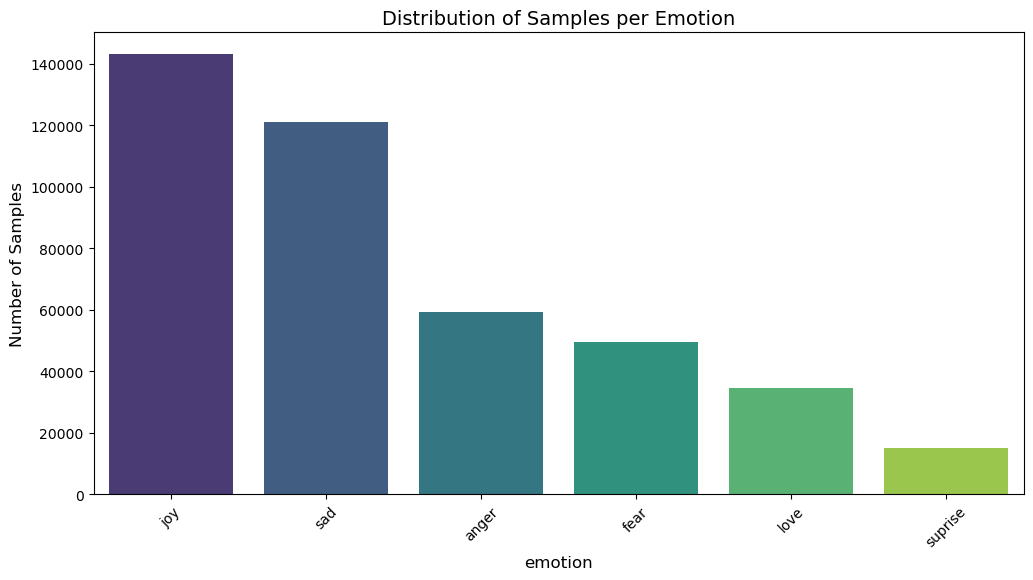

In [2]:
# Samples per emotion
emotionCount = data["emotion"].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(x=emotionCount.index, y=emotionCount.values, palette="viridis")
plt.xlabel("emotion", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.title("Distribution of Samples per Emotion", fontsize=14)
plt.xticks(rotation=45)
plt.show()

## Pre-processing
We will need to do some basic pre-processing for further analysis.
We remove stop words and convert to lower case.

In [3]:
import time

def preprocess(text : str):
    '''
        Preprocess the text to prepare it for tokenization.
        Converts text to lower case. Removes puncuation.
    '''
    text = text.lower()                     # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)     # Remove punctuation
    return text 

# Apply preproccessing
t1 = time.time()
data['sentence'] = data['sentence'].apply(preprocess)
t2 = time.time()
print(f'Pre processing takes {(t2 - t1):.2f} seconds')

Pre processing takes 0.50 seconds


Next we have to specify a set of stop words to remove and then we will visualize the most common words per emotion using word clouds.

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manveetmandal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


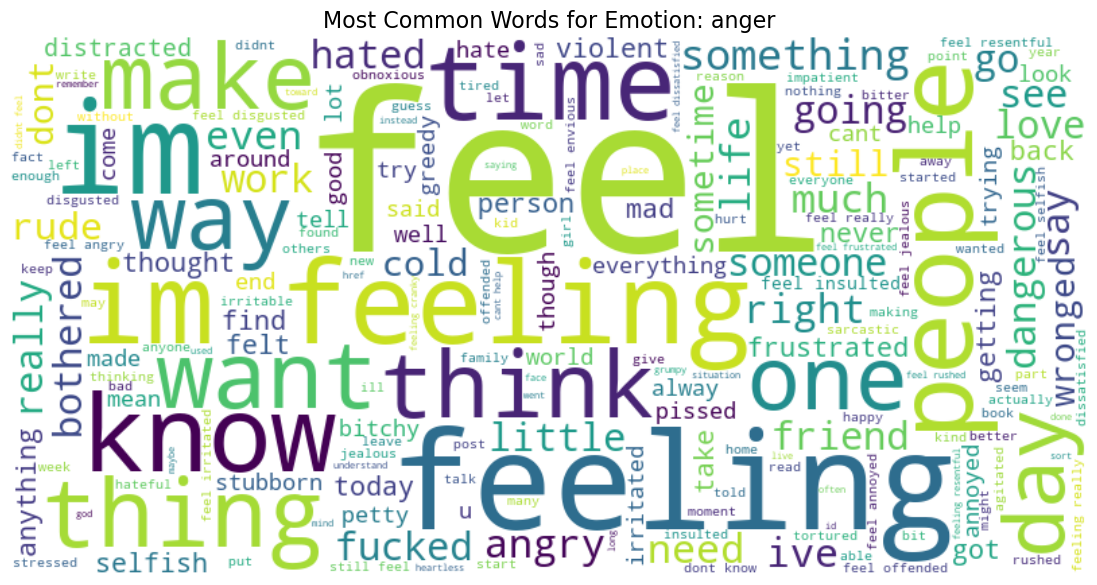

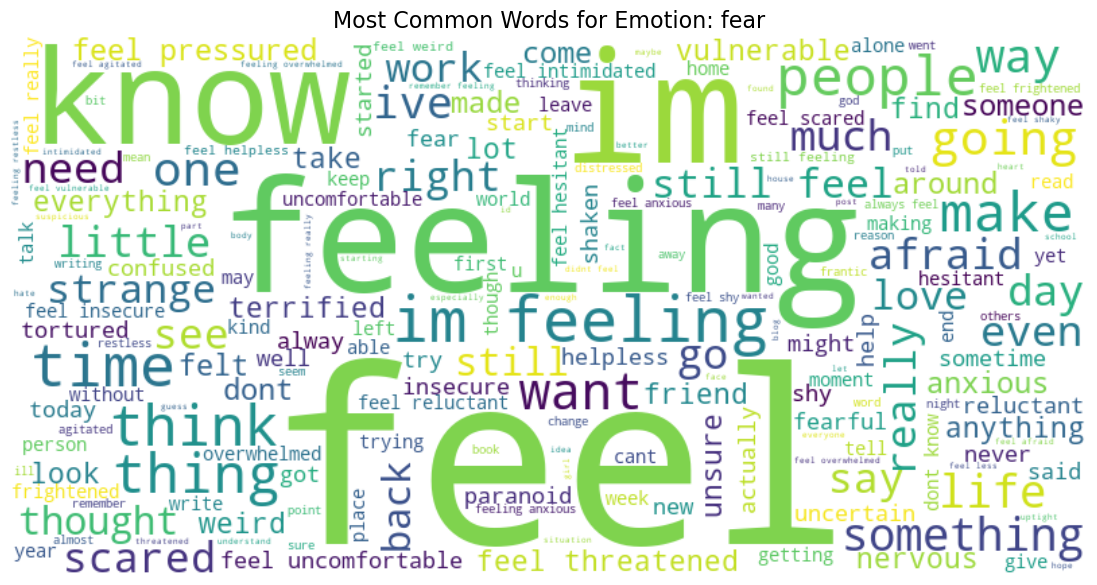

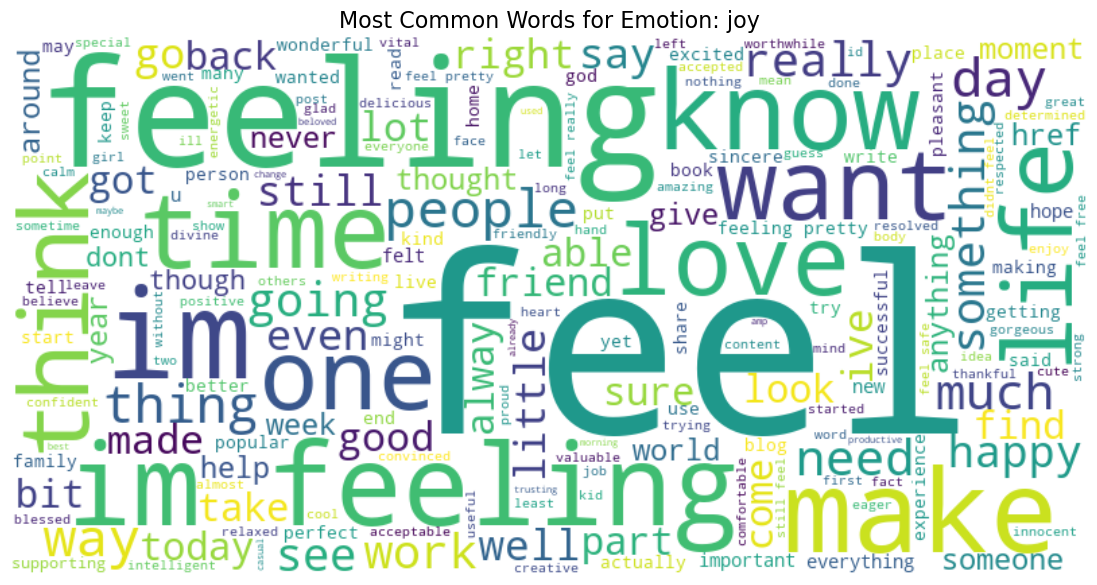

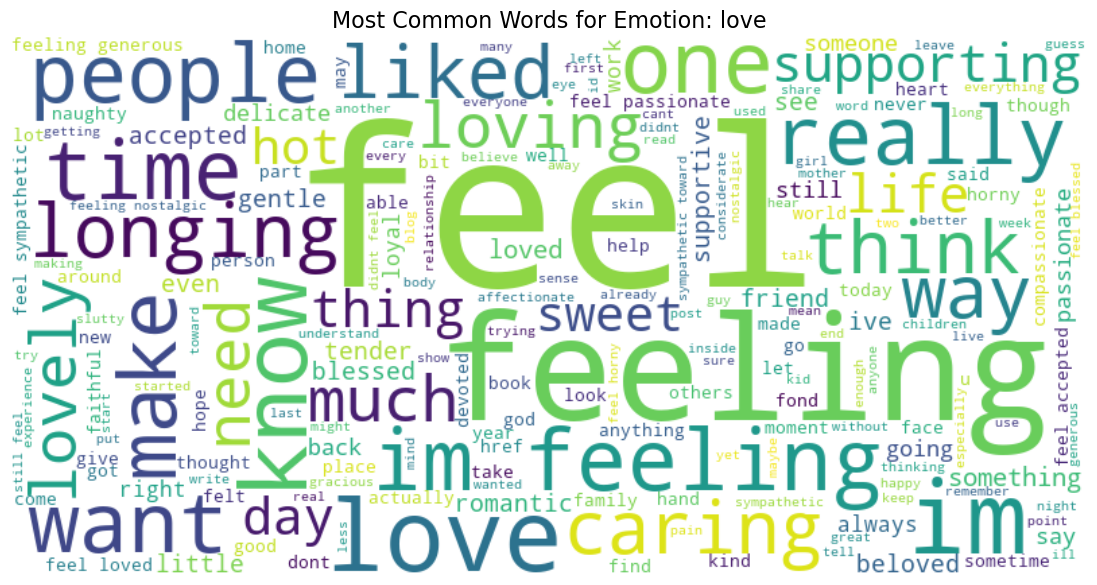

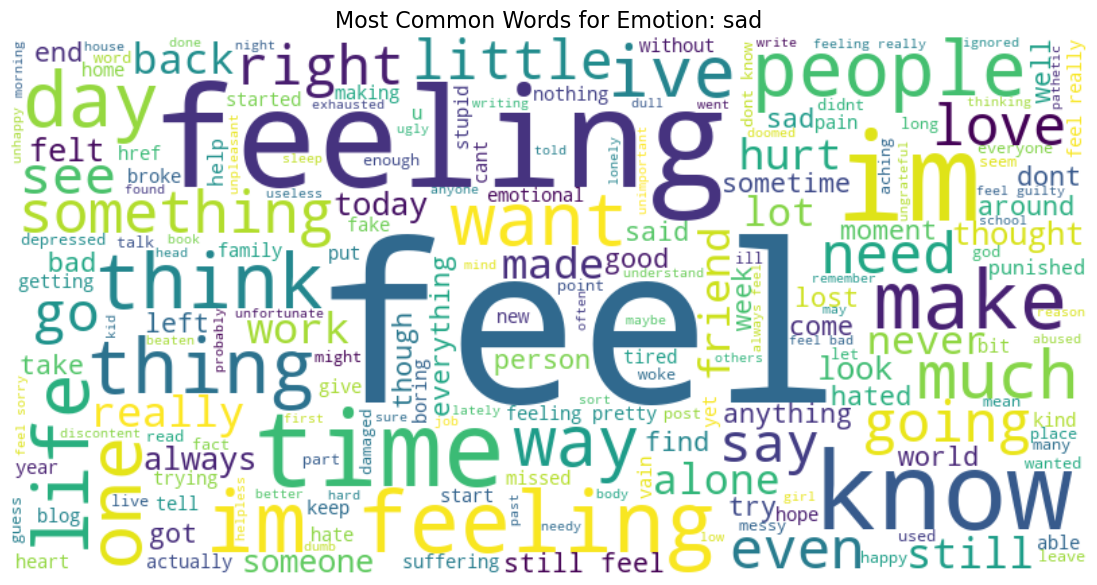

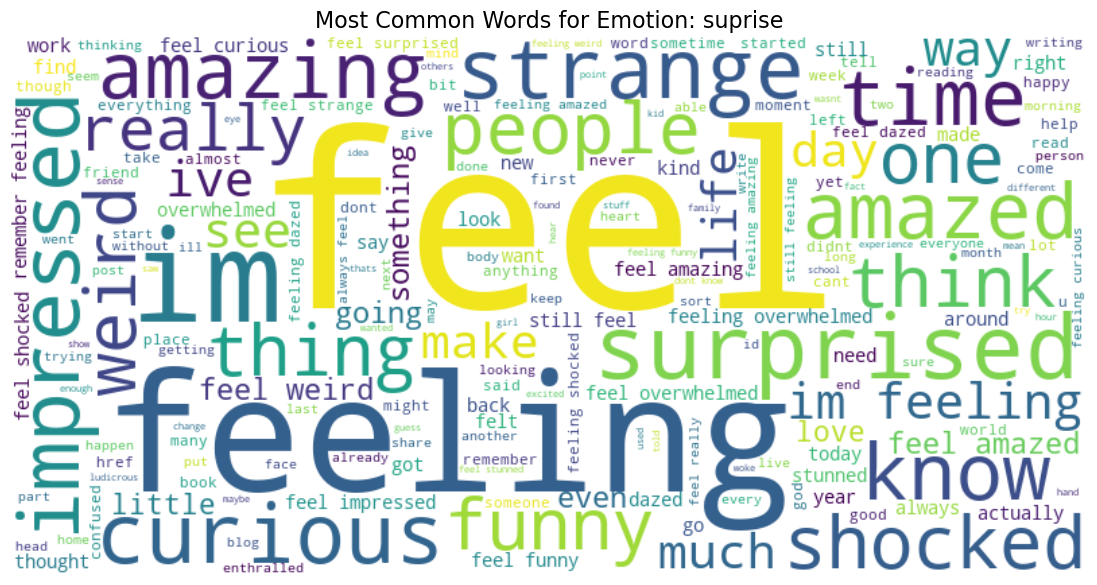

In [4]:
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords

# Specify stopwords to remove
nltk.download('stopwords')
customStopWords = set(stopwords.words('english')).union(STOPWORDS)

# Group text data by emotion
grouped = data.groupby('emotion')['sentence'].apply(lambda x: " ".join(x)).to_dict()

def wordCloudFromText(grouped):
    for emotion, text in grouped.items():
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            stopwords=customStopWords
        ).generate(text)
    
        plt.figure(figsize=(14,7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Most Common Words for Emotion: {emotion}', fontsize=16)
        plt.show()

wordCloudFromText(grouped)

## Tokenization
Now we have to extend our pre-processing to remove stopwords and form n-grams. This is done at once using TFidfVectorizer.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TFIDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=3000, stop_words=list(customStopWords), max_df=0.95, min_df=5, ngram_range=(1, 2)
)

# Do TF-IDF vectorization
t1 = time.time()
tfidfData = vectorizer.fit_transform(data['sentence'])
t2 = time.time()
print(f'Vecotrization takes {(t2 - t1):.2f} seconds')
print(tfidfData)

/Users/manveetmandal/miniconda3/envs/CPSC544/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  warnings.warn(


Vecotrization takes 5.80 seconds
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3509341 stored elements and shape (422746, 3000)>
  Coords	Values
  (0, 737)	0.11715939622802939
  (0, 2257)	0.31878345579196526
  (0, 1521)	0.49274821465431534
  (0, 1511)	0.6559429484687048
  (0, 996)	0.4599878579897327
  (1, 2257)	0.12387986546628833
  (1, 1666)	0.141398714235339
  (1, 630)	0.24199922549982858
  (1, 2)	0.17615892661299842
  (1, 2299)	0.2554501001809114
  (1, 1350)	0.2726152238962619
  (1, 1976)	0.2155966878710103
  (1, 1726)	0.1711451832401069
  (1, 2903)	0.2031431130579443
  (1, 115)	0.16146127855213063
  (1, 618)	0.18036432981655287
  (1, 1732)	0.19148290612661356
  (1, 2554)	0.17512804957707997
  (1, 1308)	0.16955904188782717
  (1, 1105)	0.0694591756123634
  (1, 216)	0.14485966539454362
  (1, 1787)	0.23022485524534217
  (1, 1985)	0.16065119111570325
  (1, 1421)	0.15564480624303317
  (1, 2693)	0.17653720123345018
  :	:
  (422743, 1813)	0.24843848137379262
  (422743, 2020

## Setup and Run Model
Now we can setup and run our model.

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Setup crossvalidation
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=36)

# Used to display report
def displayReport(report):
    report = report[['precision', 'recall', 'f1-score', 'support']]  # reorder
    report = report.round(2)  # round to 2 decimal places

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    tbl = ax.table(cellText=report.values, colLabels=report.columns, rowLabels=report.index, loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    plt.title("Classification Report", fontsize=14)
    plt.show()

# Setup model
def mnBayes(X, y):
    '''
    Used to create Multinomial Bayes model.
    '''
    # Train-Test split
    XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=36)

    # Get class weights for balancing
    classWeights = compute_class_weight(
        class_weight='balanced', classes=np.unique(yTrain), y=yTrain
    )

    # Convert to dictionary to assign corresponding weights to samples
    classWeightDict = {clss: weight for clss, weight in zip(np.unique(yTrain), classWeights)}

    # Assign sample weights corresponding to their class
    sampleWeights = np.array([classWeightDict[label] for label in yTrain])

    # Train Multinomial Bayes model
    model = MultinomialNB()
    model.fit(XTrain, yTrain, sample_weight=sampleWeights)

    # Calculate cross validation
    cvScore = cross_val_score(model, XTrain, yTrain, cv=cv, scoring='balanced_accuracy')

    # Make predictions
    yPred = model.predict(XTest)

    # Evaluate model
    accuracy = balanced_accuracy_score(yTest, yPred)
    print("Multinomial Bayes Model")
    print(f"Cross-Validation Accuracy: {cvScore.mean():.4f}")
    print(f"Accuracy is {accuracy:.4f}")
    #print(f"Classification report: \n", classification_report(yTest, yPred))
    report = pd.DataFrame(classification_report(yTest, yPred, output_dict=True)).transpose()

    return model, report, (XTest, yTest, yPred)

Multinomial Bayes Model
Cross-Validation Accuracy: 0.7799
Accuracy is 0.9099


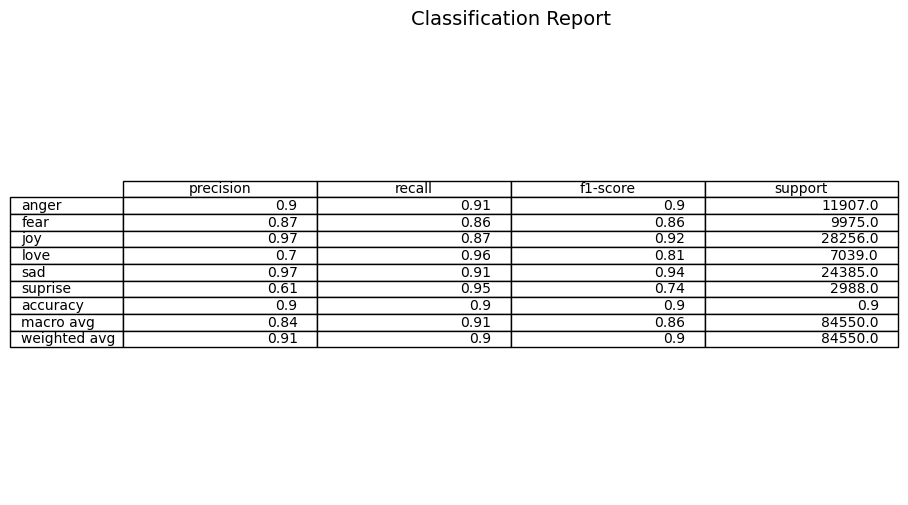

In [7]:
# Get X and Y data
X = tfidfData
y = data['emotion'].values

model, report, _ = mnBayes(X, y)
displayReport(report)

## Data Augmentation
We do data augmentation to help address the poor performance for 'suprise' and 'love

In [8]:
import nlpaug.augmenter.word as naw

nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize synonym augmenter
aug = naw.SynonymAug(aug_src='wordnet')

# Data Augmentation for emotions that is less represented than others ('love', 'suprise')
t1 = time.time()
augmented_rows = []
for i, row in data.iterrows():
    if row['emotion'] in ['love', 'suprise']:
        aug_sentence = aug.augment(row['sentence'])
        if isinstance(aug_sentence, list):
            aug_sentence = aug_sentence[0]
        augmented_rows.append({'sentence': aug_sentence, 'emotion': row['emotion']})

if augmented_rows:
    aug_df = pd.DataFrame(augmented_rows)
    data = pd.concat([data, aug_df], ignore_index=True)
    print(f"Data augmented: {len(aug_df)} new samples added.")
t2 = time.time()
print(f'Data augmentation process took {(t2 - t1):.2f} seconds')


/Users/manveetmandal/miniconda3/envs/CPSC544/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/manveetmandal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/manveetmandal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Data augmented: 49526 new samples added.
Data augmentation process took 22.34 seconds


Now we can re-train our model.

Vecotrization takes 6.89 seconds
Multinomial Bayes Model
Cross-Validation Accuracy: 0.8352
Accuracy is 0.8971


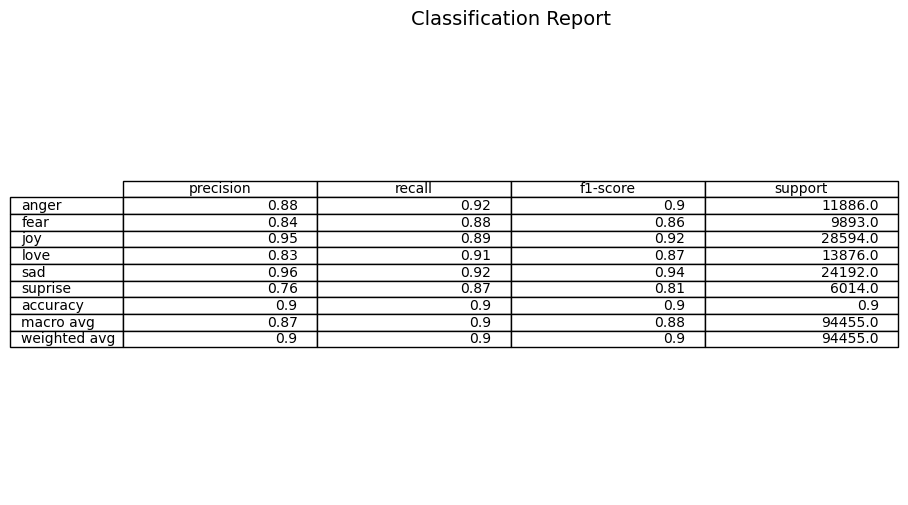

In [9]:
# Do TF-IDF vectorization
t1 = time.time()
tfidfDataAug = vectorizer.fit_transform(data['sentence'])
t2 = time.time()
print(f'Vecotrization takes {(t2 - t1):.2f} seconds')

# Get X and Y data
X = tfidfDataAug
y = data['emotion'].values

model2, report2, vals = mnBayes(X, y)
displayReport(report2)

## Results and Analysis
First we generate word clouds of the words our model associates the most with each emotion.

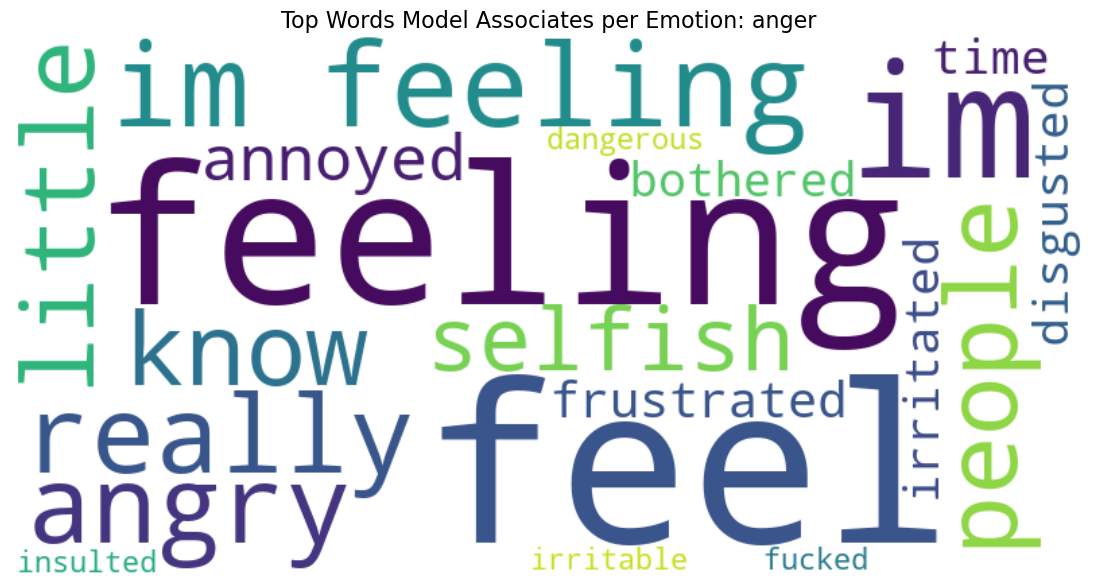

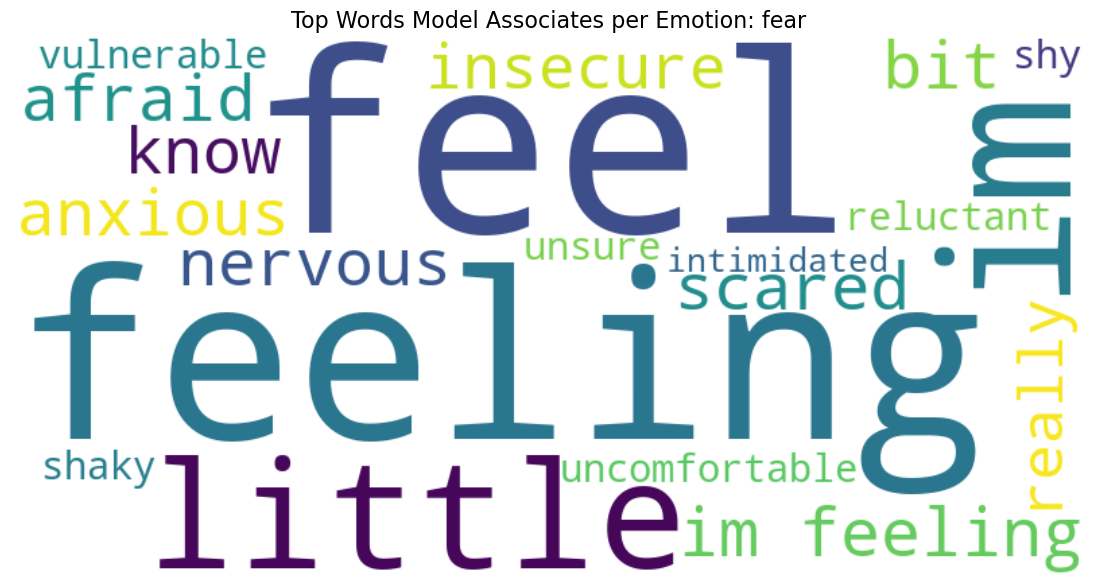

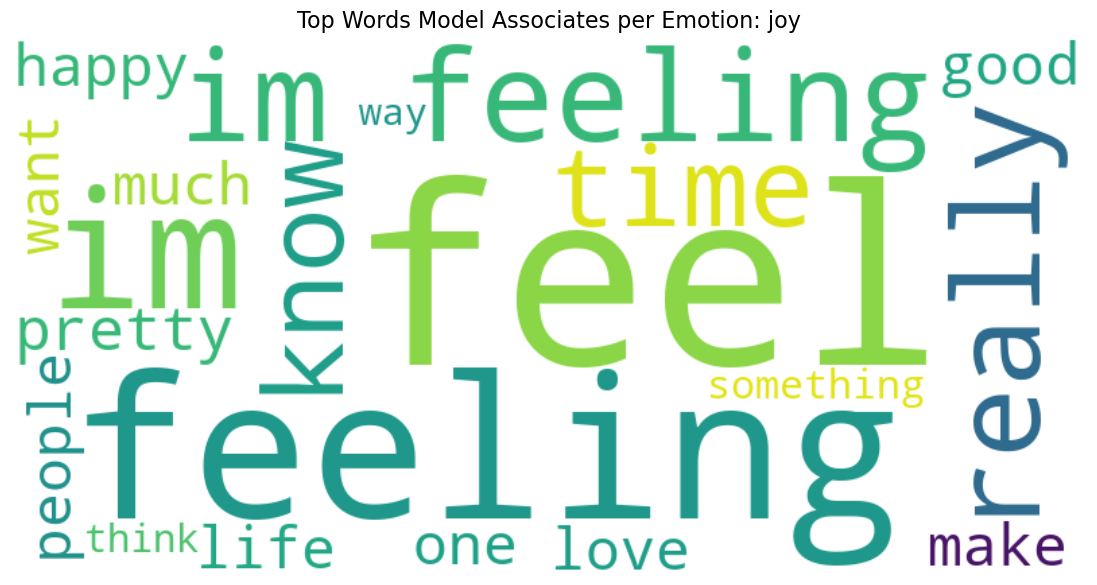

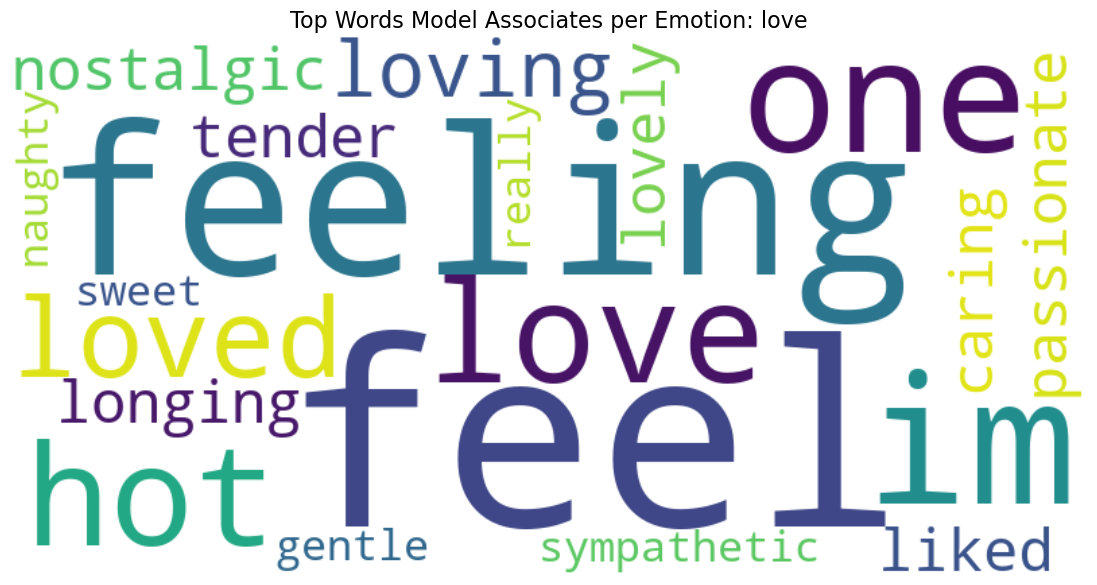

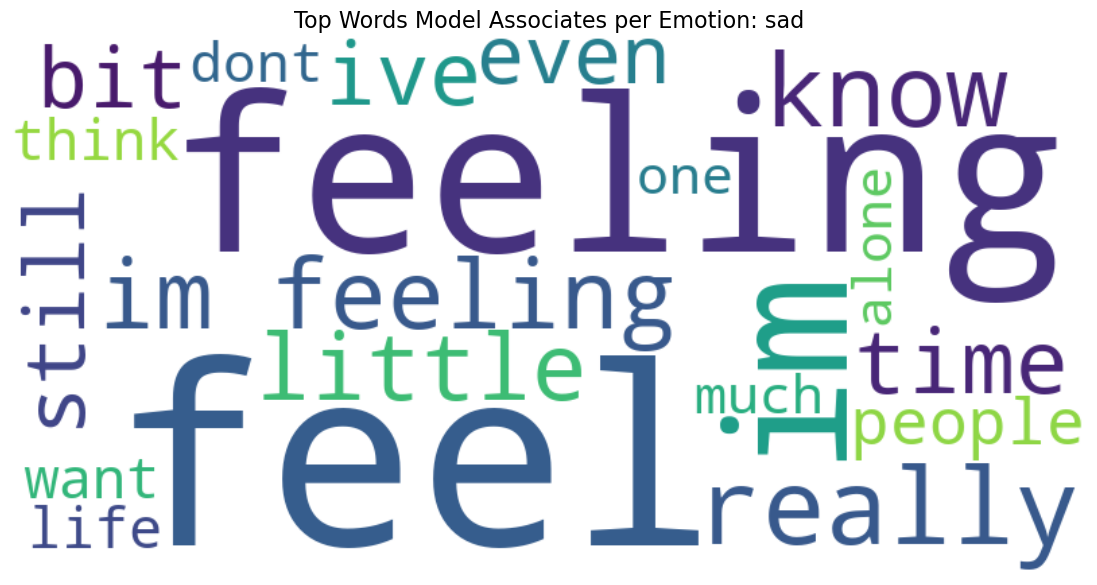

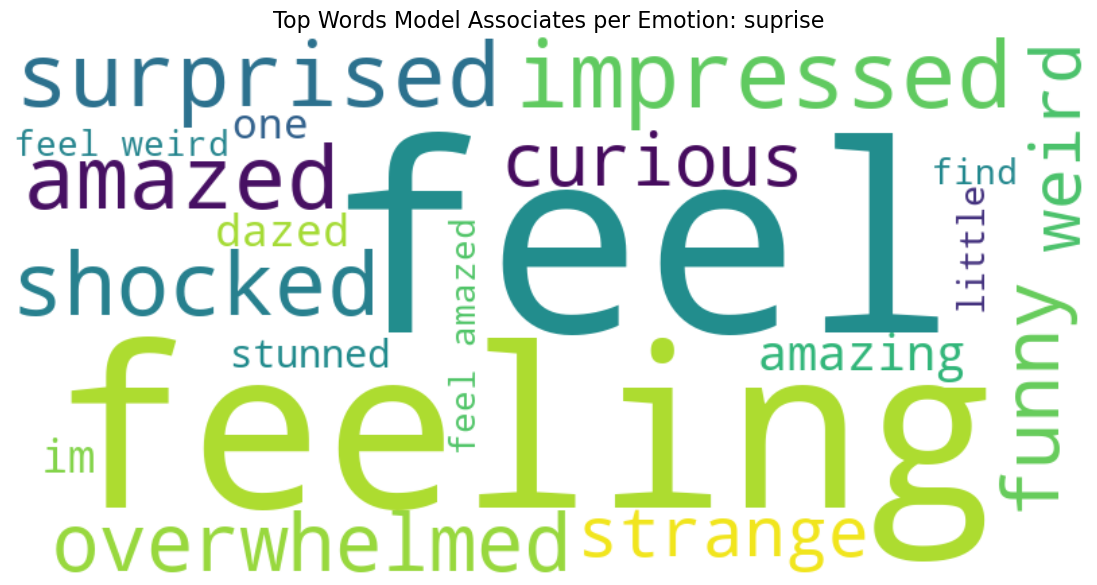

In [10]:
def plotWordClouds(vectorizer, model, n=20):
    features = vectorizer.get_feature_names_out()
    classLabels = model.classes_

    for i, classLabel in enumerate(classLabels):
        # Get log probabilities for class
        classLogProbs = model.feature_log_prob_[i]

        # Convert to actual probabilities
        classProbs = np.exp(classLogProbs)

        # Get top features and their probabilities
        topIndices = np.argsort(classProbs)[-n:]
        topWords = features[topIndices]
        topWeights = classProbs[topIndices]

        # Build a dict of {word: weight}
        wordWeights = dict(zip(topWords, topWeights))

        # Generate word cloud
        wordCloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordWeights)
        plt.figure(figsize=(14, 7))
        plt.imshow(wordCloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Top Words Model Associates per Emotion: {classLabel}', fontsize=16)
        plt.show()

plotWordClouds(vectorizer, model2)

Next we look at some samples of the text our model misclassifies.

In [11]:
def getErrors(XText, yTrue, yPred, nSamps=3):
    # Create a DataFrame from predictions
    df = pd.DataFrame({
        "text": XText,
        "true_label": yTrue,
        "predicted_label": yPred
    })

    # Filter misclassified samples
    misclassified = df[df["true_label"] != df["predicted_label"]]

    # Group by predicted label and sample a few
    samples = (
        misclassified
        .groupby("predicted_label")
        .apply(lambda x: x.sample(min(nSamps, len(x)), random_state=42))
        .reset_index(drop=True)
    )

    return samples

# We need to regenerate the X data but using the text data this time
XTrain, XTest, yTrain, yTest = train_test_split(data['sentence'], data['emotion'], test_size=0.2, random_state=36)
print(getErrors(XTest, vals[1], vals[2]).to_markdown(index=False))

| text                                                                                                                                                                                                                                                                           | true_label   | predicted_label   |
|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------|:------------------|
| i feel ya this was my cd when i hated the world and wanted to watch everything i saw burn                                                                                                                                                                                      | sad          | anger             |
| i feel really agitated lately i cannot tell you why because i dont k

/var/folders/2b/c45yc_ls24qgng55ndt27fsh0000gn/T/ipykernel_5717/2972666623.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(nSamps, len(x)), random_state=42))


Finally we do a Model Confidence plot for correct vs incorrect predictions.

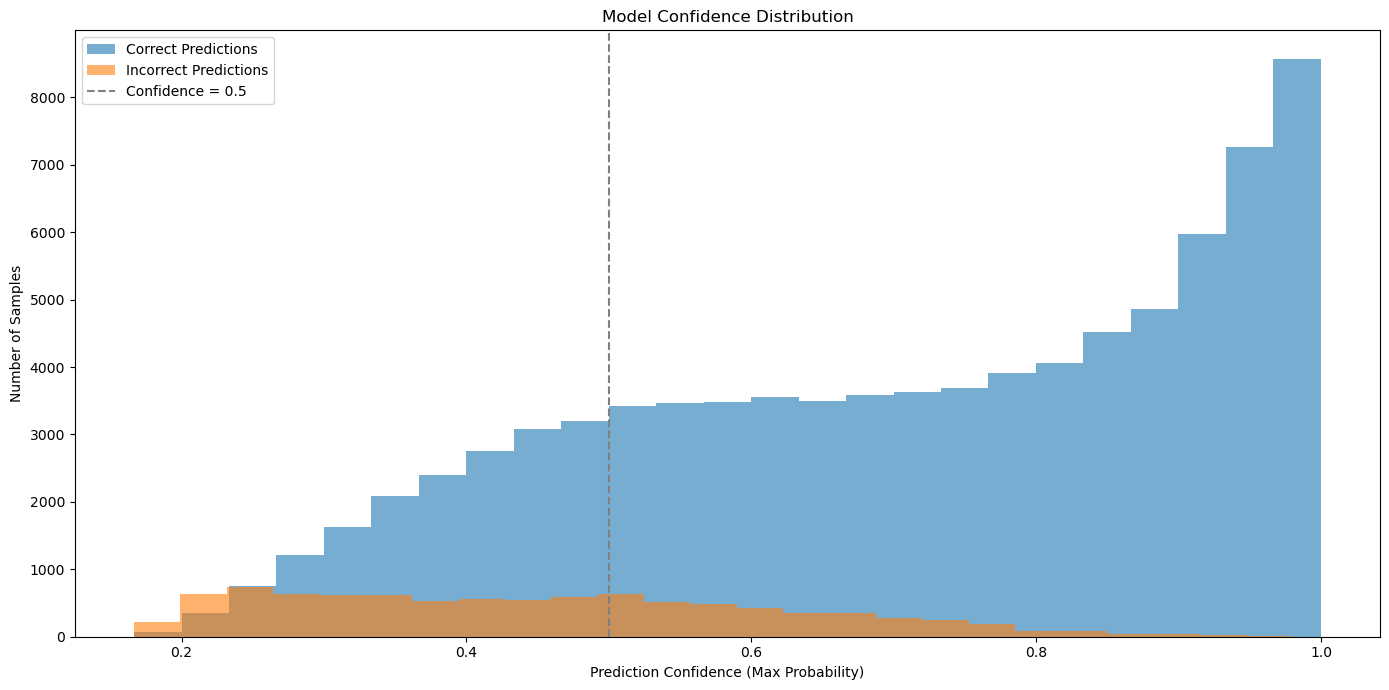

In [12]:
def plotModelConfidence(model, Xtfidf, yTrue, yPred):
    probs = model.predict_proba(Xtfidf)
    maxProbs = np.max(probs, axis=1)

    correct = (yPred == yTrue)

    plt.figure(figsize=(14, 7))
    plt.hist(maxProbs[correct], bins=25, alpha=0.6, label='Correct Predictions')
    plt.hist(maxProbs[~correct], bins=25, alpha=0.6, label='Incorrect Predictions')
    plt.axvline(x=0.5, color='gray', linestyle='--', label='Confidence = 0.5')
    plt.xlabel('Prediction Confidence (Max Probability)')
    plt.ylabel('Number of Samples')
    plt.title('Model Confidence Distribution')
    plt.legend()
    plt.tight_layout()
    plt.show()

plotModelConfidence(model2, vals[0], vals[1], vals[2])